### Introduction
Using Python and its libraries, you will gather data from a variety of sources and in a variety
of formats, assess its quality and tidiness, then clean it. This is called data wrangling.

The dataset I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter
user @dog_rates, also known as WeRateDogs.

The Twitter account WeRateDogs (@dog_rates) is devoted to humorously reviewing pictures
of dogs doing adorable poses. It has acquired over 8.7 million followers.

#### Project details:

The tasks of this project are as follows:
    - Data wrangling, which consists of:
        - Gathering data
        - Assessing data
        - Cleaning data
    - Visualization
    - Reporting on
        - our data wrangling efforts (Report 1- Wrangle report)
        - our data analyses and visualizations (Report 2- act-report)

In [1]:
#import important packages and libraries

import pandas as pd
import numpy as np

import requests
import tweepy
import os
import json
import time
import re

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Gathering Data

#### Load dataset of Twitter archive provided by udacity

In [2]:

twitter_df= pd.read_csv("twitter-archive-enhanced.csv")

In [8]:
twitter_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


#### Download the dog image prediction files from the Udacity server using the Request library via URL


In [14]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

In [3]:
#Load Image prediction file
image_pred = pd.read_csv("image-predictions.tsv", sep='\t')

In [146]:
image_pred.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


#### Twitter API

    Source: https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

In [22]:
#Enter VAlID API KEYS
CONSUMER_KEY = "$%^&*&^%$#$%^&*"
CONSUMER_SECRET = "#$%^&*(*&^%$%^&*"
ACCESS_TOKEN = "*&^%$#%^&*&^%"
ACCESS_TOKEN_SECRET = "@#$%^&*&^%$#$%^&"


In [25]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [38]:
import time
# start timer
start = time.time() 

# List of tweets
df_list = []

# List of Exceptions(errors)
err_list = []

# For loop to add  matched tweet_json to df_list
#Extract Tweet_id, favorites, retweet, followers

for tweet_id in twitter_df['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')._json 
        favorites = tweet['favorite_count'] 
        retweets = tweet['retweet_count'] 
        followers = tweet['user']['followers_count'] 
        
            
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers)})
        
    except Exception as e:
        print(str(tweet_id))
        err_list.append(tweet_id)

#end timer
end = time.time() 
print((end - start)/(1000*60))

888202515573088257
873697596434513921
872668790621863937
872261713294495745
869988702071779329
866816280283807744
861769973181624320
856602993587888130
851953902622658560
845459076796616705
844704788403113984
842892208864923648
837366284874571778
837012587749474308
829374341691346946
827228250799742977
812747805718642688
802247111496568832
779123168116150273
775096608509886464
771004394259247104
770743923962707968
759566828574212096
754011816964026368
680055455951884288
0.051535279897848764


In [39]:
# length of the result
print("Number of Results", len(df_list))

# length of the errors
print("Number of Errors", len(err_list))

Number of Results 2331
Number of Errors 25


In [40]:
# Create DataFrames from json
tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers'])
# Save the dataFrame 
tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [4]:
tweet_api=pd.read_csv("tweet_json.txt", encoding = 'utf-8')
tweet_api.head(2)

,tweet_id,favorites,retweets,user_followers
0,892420643555336193,36132,7695,8781173
1,892177421306343426,31153,5690,8781173


### Assessing Data'



#### Visual assessment
All gathered data is displayed in the Jupyter Notebook for visual assessment purposes.
Once displayed, data can additionally be assessed in an external application (e.g. Excel, text editor).

In [11]:
twitter_df.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1720,680145970311643136,NaN,NaN,2015-12-24 22:00:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Kawhi. He was doing fine until hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680145970...,10,10,Kawhi,None,None,pupper,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilli Bee &amp; Honey Bear. Unfortunat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758854675...,11,10,Lilli,None,None,None,None
2050,671497587707535361,NaN,NaN,2015-12-01 01:14:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pip. He is a ship captain. Many years ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671497587...,11,10,Pip,None,None,None,None
1771,678334497360859136,NaN,NaN,2015-12-19 22:02:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rosie. She has a snazzy bow tie and a ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678334497...,10,10,Rosie,None,None,None,None
392,826115272272650244,NaN,NaN,2017-01-30 17:10:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ike. He's demonstrating the pupmost re...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826115272...,13,10,Ike,None,None,None,None
1199,716791146589110272,NaN,NaN,2016-04-04 00:55:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jennifur. She's supposed to be navigating...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716791146...,11,10,Jennifur,None,None,None,None
1525,690400367696297985,NaN,NaN,2016-01-22 05:07:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eriq. His friend just reminded him of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690400367...,10,10,Eriq,None,None,None,None
2067,671141549288370177,NaN,NaN,2015-11-30 01:39:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Neat pup here. Enjoys lettuce. Long af ears. S...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671141549...,9,10,None,None,None,None,None
1198,716802964044845056,NaN,NaN,2016-04-04 01:41:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Link. He struggles with couches. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716802964...,10,10,Link,None,None,None,None
160,860924035999428608,NaN,NaN,2017-05-06 18:27:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @tallylott: h*ckin adorable promposal. 13/1...,8.609145e+17,363890752.0,2017-05-06 17:49:42 +0000,https://twitter.com/tallylott/status/860914485...,13,10,None,None,None,None,None


In [10]:
image_pred.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
146,668627278264475648,https://pbs.twimg.com/media/CUdw9thWsAA4mB9.jpg,1,French_bulldog,0.965403,True,pug,0.008604,True,Boston_bull,0.008004,True
342,672256522047614977,https://pbs.twimg.com/media/CVRVvRMWEAIBKOP.jpg,1,ostrich,0.999004,False,Arabian_camel,0.000512,False,llama,0.000147,False
1160,734776360183431168,https://pbs.twimg.com/media/CjJzMlBUoAADMLx.jpg,1,Siberian_husky,0.304902,True,Eskimo_dog,0.155147,True,malamute,0.050942,True
110,667886921285246976,https://pbs.twimg.com/media/CUTPnPCW4AI7R0y.jpg,1,Pomeranian,0.800432,True,Pekinese,0.168445,True,Chihuahua,0.008950,True
1590,798644042770751489,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True
1910,853299958564483072,https://pbs.twimg.com/media/C9eHyF7XgAAOxPM.jpg,1,grille,0.652280,False,beach_wagon,0.112846,False,convertible,0.086252,False
922,702217446468493312,https://pbs.twimg.com/media/Cb7HCMkWEAAV9zY.jpg,1,golden_retriever,0.242419,True,chow,0.226800,True,cocker_spaniel,0.194086,True
1638,806629075125202948,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
892,699413908797464576,https://pbs.twimg.com/media/CbTRPXdW8AQMZf7.jpg,1,Samoyed,0.517479,True,malamute,0.155935,True,Eskimo_dog,0.095001,True
872,697990423684476929,https://pbs.twimg.com/media/Ca_ClYOW0AAsvpE.jpg,2,Pembroke,0.984783,True,Cardigan,0.015018,True,Shetland_sheepdog,0.000074,True


In [13]:
tweet_api.sample(20)

,tweet_id,favorites,retweets,user_followers
1742,678396796259975168,1572,408,8781173
1995,672095186491711488,964,355,8781173
1054,739485634323156992,7108,2913,8781173
1469,692752401762250755,6778,3624,8781173
1425,696100768806522880,1922,650,8781173
1416,696886256886657024,4829,1792,8781173
2140,669367896104181761,442,143,8781173
1430,695446424020918272,4366,1799,8781173
2014,671547767500775424,1294,565,8781173
938,750868782890057730,4793,1366,8781173


#### Programmatic assessment

By using Pandas' functions and/or methods are used to assess the data

In [6]:
#summary of Twitter archieve data
twitter_df.info()
twitter_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

(2356, 17)

In [43]:
#summary of image Prediction data
image_pred.info()
image_pred.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


(2075, 12)

In [44]:
#summary of Twitter API data
tweet_api.info()
tweet_api.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
tweet_id          2331 non-null int64
favorites         2331 non-null int64
retweets          2331 non-null int64
user_followers    2331 non-null int64
dtypes: int64(4)
memory usage: 72.9 KB


(2331, 4)

In [45]:
twitter_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [46]:
image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [47]:
tweet_api.describe()

,tweet_id,favorites,retweets,user_followers
count,2.331000e+03,2331.000000,2331.000000,2331.0
mean,7.419079e+17,7544.194766,2699.496353,8781173.0
std,6.823170e+16,11709.192111,4564.002755,0.0
min,6.660209e+17,0.000000,1.000000,8781173.0
25%,6.782670e+17,1316.000000,546.000000,8781173.0
50%,7.182469e+17,3282.000000,1266.000000,8781173.0
75%,7.986692e+17,9238.000000,3138.500000,8781173.0
max,8.924206e+17,155796.000000,77651.000000,8781173.0


In [14]:
#check the duplicated values in Twitter_df
twitter_df['tweet_id'].duplicated().sum()

0

In [15]:
#check the duplicated values in Image Predictions
image_pred['tweet_id'].duplicated().sum()

0

In [23]:
#check the duplicated values in Image Predictions
image_pred['jpg_url'].duplicated().sum()

66

In [16]:
#check the duplicated values in Tweet_api
tweet_api['tweet_id'].duplicated().sum()

0

In [22]:
twitter_df.rating_denominator.count()

2356

In [20]:
twitter_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
twitter_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [73]:
#check Predictions
print(image_pred.p1_dog.value_counts())
print(image_pred.p2_dog.value_counts())
print(image_pred.p3_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64
True     1553
False     522
Name: p2_dog, dtype: int64
True     1499
False     576
Name: p3_dog, dtype: int64


### Quality Assessment

Twitter archive data:
      
     
     1) timestamp is an 'object' type. 
     2) Looking programmatically, some names are inaccurate such as "a", "an", "the", "very", "by", etc.
     3) name has values that are the string "None" instead of NaN
     4) In 2365 only 23 cases where the denominator of rating is not equal to 10. These entries will be removed.
     5) Calculating Ratings of the Dog
     6) There is no duplicated tweetids found.
     7) There are many columns in this dataframe are not for use for analysis they need to be dropped.
 
Image Predication Data:
    
    1) The "p1" and "p1_conf" columns will be renamed with more explanatory titles.(image Predications)
    2) There is no duplicated tweet ids found in Data set.
    3) Drop 66 jpg_url duplicated
    4) Drop columns that won't be used for analysis
    
Tweet API _Json Data:
    
    1) There is no duplicated tweet ids found in Data set.
    
    
    
### Tidiness Assessments

    1) Change columns "doggo", "floofer", "pupper", and "puppo" from wide to long format.
    2) Have to extract the url from text column

- Drop columns that won't be used for analysis in al dataset
- After all these assessment steps Merge all the data into "twitter_archive_master.csv"

## Cleaning Data

In [24]:
#copy all the dataset for cleaning data

twitter_df_clean= twitter_df.copy()
image_pred_clean= image_pred.copy()
tweet_api_clean = tweet_api.copy()

#### Twitter archive data: (twitter_df_clean)

Quality Issues

In [25]:
#define
#1) convert timestamp to datetime
twitter_df_clean['timestamp'] = pd.to_datetime(twitter_df_clean['timestamp'])

In [26]:
#test
twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[

In [27]:
#define
# 2) Looking programmatically, some names are inaccurate such as "a", "an", "the", "very", "by", etc.
# 3) Name has values that are the string "None" instead of NaN

#So you may do some kind of masking to weed out names with lowercase letters only:
# Source: https://knowledge.udacity.com/questions/45245

mask = twitter_df_clean.name.str.islower()
column_name = 'name'
twitter_df_clean.loc[mask, column_name] = np.nan



In [28]:
# Replace all "None" instead of NaN
twitter_df_clean['name'].replace('None', 
                        np.nan,
                       inplace = True)

In [32]:
#Test
twitter_df_clean['name'].sample(10)

1739    William
829         NaN
239        Tuck
2203       Hanz
1723        NaN
1178    Harnold
1880     Mollie
397       Pablo
1452        NaN
1682    Charlie
Name: name, dtype: object

In [33]:
#define
# 4) In 2365 only 23 cases where the denominator of rating is not equal to 10. These entries will be removed

twitter_df_clean.drop(twitter_df_clean[twitter_df_clean.rating_denominator != 10].index, inplace = True)

In [35]:
twitter_df_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

In [36]:
#define
# 5) Calculating Ratings of the Dog

twitter_df_clean['rating']= twitter_df_clean['rating_numerator']/twitter_df_clean['rating_denominator']

In [38]:
#test
twitter_df_clean['rating'].sample(10)

1155    1.2
1029    0.7
1474    1.0
2092    0.5
2313    1.0
1564    1.0
2350    1.0
1225    1.0
2179    1.2
1452    1.3
Name: rating, dtype: float64

## Image Predication Data: (image_pred_clean)

In [41]:
#define
#1) The "p1" and "p1_conf" columns will be renamed with more explanatory titles.(image Predications)
image_pred_clean.rename(columns={'p1':'prediction_1',
                                  'p1_conf': 'confidence_1'}, inplace=True)

In [43]:
#test
image_pred_clean['prediction_1'].head(5)

0    Welsh_springer_spaniel
1                   redbone
2           German_shepherd
3       Rhodesian_ridgeback
4        miniature_pinscher
Name: prediction_1, dtype: object

In [44]:
image_pred_clean['confidence_1'].describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: confidence_1, dtype: float64

In [45]:
#define
# 2)Drop 66 jpg_url duplicated

image_pred_clean = image_pred_clean.drop_duplicates(subset=['jpg_url'], keep='last')


In [47]:
#test
sum(image_pred_clean['jpg_url'].duplicated())

0

### Tidiness Assessments



In [48]:
#define
# 1) Change columns "doggo", "floofer", "pupper", and "puppo" to the columns into the new dog_type colunn

twitter_df_clean['dog_type'] = twitter_df_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [50]:
#test
twitter_df_clean.dog_type.value_counts()

pupper     259
doggo       92
puppo       37
floofer      4
Name: dog_type, dtype: int64

In [66]:
twitter_df_clean['dog_type'].sample(5)

1563    pupper
1102       NaN
1181       NaN
1950       NaN
1504       NaN
Name: dog_type, dtype: object

In [67]:
#define
#2)Have to extract the url from text column.
#Source : https://www.tutorialspoint.com/python_text_processing/python_extract_url_from_text.htm

twitter_df_clean.text[0]


"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [71]:
#code
# to separate text from url split on 'https' and get first item
twitter_df_clean['tweet_url'] = twitter_df_clean['text'].str.extract(r'(https?://t.co/[A-Za-z0-9]+)')

twitter_df_clean['text'] = twitter_df_clean['text'].apply(lambda x:x.split('https')[0])

In [72]:
#test
twitter_df_clean.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 "

#### Merge all Dataset
    Source: https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html

In [74]:
twitter_df_clean.shape , image_pred_clean.shape , tweet_api_clean.shape

((2333, 20), (2009, 12), (2331, 4))

In [80]:
twitter_all = pd.merge(left=twitter_df_clean,
                                 right=image_pred_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

twitter_all = twitter_all.merge(tweet_api_clean, on='tweet_id', how='inner')

In [76]:
twitter_all.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,user_followers
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.07611,False,36132,7695,8781173


#### Drop columns that won't be used for analysis in al dataset

In [81]:
#define
twitter_all.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'rating', 'dog_type', 'tweet_url', 'jpg_url', 'img_num', 'prediction_1',
       'confidence_1', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'favorites', 'retweets', 'user_followers'],
      dtype='object')

In [82]:
#code
twitter_all = twitter_all.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 
                                'retweeted_status_id', 'retweeted_status_user_id','doggo', 'floofer', 'pupper', 'puppo',
                                'retweeted_status_timestamp','rating_numerator','rating_denominator',
                                'expanded_urls', 'confidence_1', 'p1_dog', 'p2', 'p2_conf', 'p2_dog',
                                'p3', 'p3_conf','p3_dog',
                                'img_num','source','jpg_url'], axis=1)

In [83]:
#test
twitter_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 0 to 1975
Data columns (total 11 columns):
tweet_id          1976 non-null int64
timestamp         1976 non-null datetime64[ns, UTC]
text              1976 non-null object
name              1337 non-null object
rating            1976 non-null float64
dog_type          319 non-null object
tweet_url         1976 non-null object
prediction_1      1976 non-null object
favorites         1976 non-null int64
retweets          1976 non-null int64
user_followers    1976 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(5)
memory usage: 185.2+ KB


In [84]:
# Save the dataFrame 
twitter_all.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [85]:
twitter_archive_master= pd.read_csv("twitter_archive_master.csv")
twitter_archive_master.shape

(1976, 11)

In [87]:
twitter_archive_master.sample(5)

,tweet_id,timestamp,text,name,rating,dog_type,tweet_url,prediction_1,favorites,retweets,user_followers
277,829141528400556032,2017-02-08 01:35:19+00:00,This is Malcolm. He goes from sneaky tongue sl...,Malcolm,1.2,NaN,https://t.co/rHwfySggqR,golden_retriever,24522,7391,8781173
1371,680440374763077632,2015-12-25 17:30:01+00:00,Merry Christmas. My gift to you is this tiny u...,NaN,1.1,NaN,https://t.co/UKqIAnR3He,space_heater,1433,496,8781173
888,726828223124897792,2016-05-01 17:38:46+00:00,This is Bloop. He's a Phoenician Winnebago. To...,Bloop,1.2,NaN,https://t.co/DWNrPPXgHA,miniature_pinscher,3525,994,8781173
1061,703611486317502464,2016-02-27 16:03:45+00:00,Meet Scooter. He's experiencing the pupper equ...,Scooter,1.0,pupper,https://t.co/JSmX1FIEaW,Pembroke,3821,1519,8781173
1974,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,NaN,0.7,NaN,https://t.co/r7mOb2m0UI,redbone,121,42,8781173


## Visualization 

- Favorite Tweets 
- Highest and Lowest retweeted Tweet Id.
- Plot tweets vs Favorites
- Pair plot 
- Most Rated Breeds (pie Chart)
 

In [88]:
# Favorite Tweets by tweet id
twitter_archive_master.sort_values('favorites', ascending=False)[['tweet_id','favorites']].head(4)

,tweet_id,favorites
794,744234799360020481,155796
316,822872901745569793,132775
108,866450705531457537,116192
825,739238157791694849,115107


In [89]:
# Highest retweet Tweet Id
twitter_archive_master.sort_values('retweets', ascending=False)[['tweet_id','retweets']].head(3)

,tweet_id,retweets
794,744234799360020481,77651
825,739238157791694849,57600
316,822872901745569793,43737


In [90]:
#Lowest retweet Tweet Id
twitter_archive_master.sort_values('retweets', ascending=True)[['tweet_id','retweets']].head(3)


,tweet_id,retweets
1959,666102155909144576,11
1940,666447344410484738,18
165,851861385021730816,19


#### Dog breed count by Predictions1

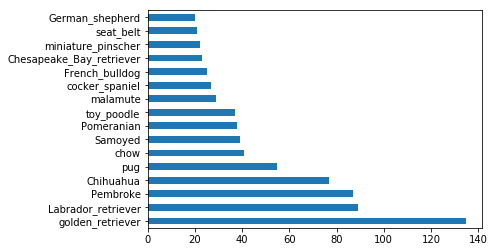

In [91]:
df_dog_type = twitter_archive_master.groupby('prediction_1').filter(lambda x: len(x) >= 20)
df_dog_type['prediction_1'].value_counts().plot(kind = 'barh')

**By seeing the Prediction of dog_breed we understand that "Golden_retriever" is the most Favourite dog.**

Text(0.5, 1.0, 'Retweets and favorites Scatter plot')

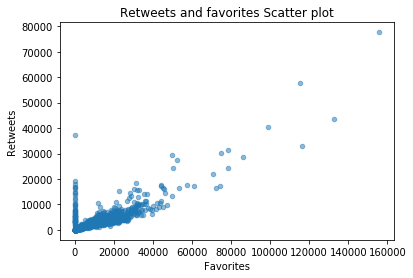

In [92]:
#plot tweets vs Favourites
twitter_archive_master.plot(kind='scatter',x='favorites',y='retweets', alpha = 0.5)
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')

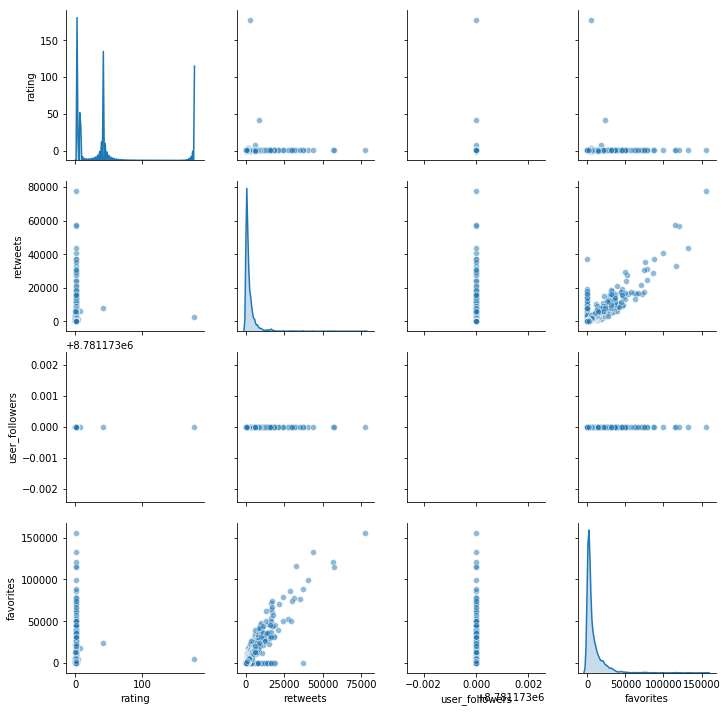

In [375]:
sns.pairplot(twitter_archive_master, 
             vars = ['rating', 'retweets','user_followers' ,'favorites'], 
             diag_kind = 'kde', plot_kws = {'alpha': 0.5});

(-1.1284900676315404,
 1.0997686432988882,
 -1.2255576627035225,
 1.2435445800834766)

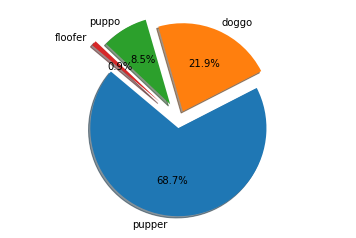

In [93]:
#Most Rated Breeds

labels = ['pupper','doggo','puppo','floofer']
sizes = twitter_archive_master['dog_type'].value_counts()
colors = [ 'coral', 'lightskyblue']
explode = ( 0.1,0.1,0.2, 0.3)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')


Text(0.5, 0.98, 'Dogs Type')

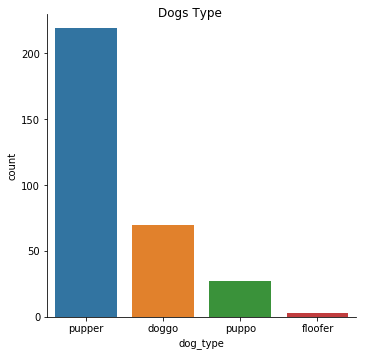

In [94]:
order= ['pupper','doggo','puppo','floofer']
a=sns.catplot(data=twitter_archive_master, x='dog_type', kind='count',order=order)
a.fig.suptitle('Dogs Type' )
